<a href="https://colab.research.google.com/github/parham/glo7030_Travail_Pratique_2/blob/main/question_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp -R "/content/drive/MyDrive/DL - GLO7030/Development/glo7030_Travail_Pratique_2/img" .

![Université Laval](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/ulaval.jpg?raw=1)
 # <center><b>GLO-4030/GLO-7030 : Apprentissage par réseaux de neurones profonds</b> </center>
 # <center><b>Travail Pratique 2</b></center>
 ***
 __Course__: GLO-4030/GLO-7030 : Apprentissage par réseaux de neurones profonds <br>
 __Title__: Travail Pratique 2 <br>
 __Semester__: Winter 2021 <br>
 __Lecturer__: Dr. Pascal Germain <br>
 __Author__: Parham Nooralishahi <br>
 __Organization__: Université Laval <br>
 ***

 ## Question 2 - Neural Style Transfer (45%)

 This code is modified version of <a href="https://pytorch.org/tutorials/advanced/neural_style_tutorial.html">PyTorch Tutorial</a>

 ## NEURAL TRANSFER USING PYTORCH
 This code explains how to implement the Neural-Style algorithm developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge. Neural-Style, or Neural-Transfer, allows you to take an image and reproduce it with a new artistic style. <br>


 __What does it need?__ The algorithm takes three images, an input image, a content-image, and a style-image. <br>

 __What does it provide?__ It changes the input to resemble the content of the content-image and the artistic style of the style-image. <br>

 #### Underlying Principle
 The principle is simple: we define two distances, one for the content $D_C$ and one for the style $D_S$. $D_C$ measures how different the content is between two images while $D_S$ measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image. Now we can import the necessary packages and begin the neural transfer. <br>

 #### The required packages
 * torch, torch.nn, numpy (indispensables packages for neural networks with PyTorch)
 * torch.optim (efficient gradient descents)
 * PIL, PIL.Image, matplotlib.pyplot (load and display images)
 * torchvision.transforms (transform PIL images into tensors)
 * torchvision.models (train or load pre-trained models)
 * copy (to deep copy the models; system package)

In [5]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import shutil
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


 Next, we need to choose which device to run the network on and import the content and style images. Running the neural transfer algorithm on large images takes longer and will go much faster when running on a GPU.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  ### Content Loss

 The content loss is a function that represents a weighted version of the content distance for an individual layer. The function takes the feature maps of a layer in a network processing input and returns the weighted content distance between the image and the content image. The distance $∥FXL−FCL∥^2$ is the mean square error between the two sets of feature maps. <br>

 We will add this content loss module directly after the convolution layer(s) that are being used to compute the content distance. This way each time the network is fed an input image the content losses will be computed at the desired layers and because of auto grad, all the gradients will be computed. <br>

In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


  ### Style Loss

 The style loss module is implemented similarly to the content loss module. It will act as a transparent layer in a network that computes the style loss of that layer. In order to calculate the style loss, we need to compute the gram matrix. <br>

 A gram matrix is the result of multiplying a given matrix by its transposed matrix. In this application the given matrix is a reshaped version of the feature maps of a layer. <br>

In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


 ### Normalization

 VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network. <br>

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential.

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


 ### Importing Neural Network's model

 We will use a 19 layer VGG network like the one used in the related paper.
 PyTorch’s implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval(). <br>

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


 ### Module Initialization

 A Sequential module contains an ordered list of child modules. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted. <br>

In [11]:

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=['conv_4'],
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


 ### Gradient Descent

 we will use L-BFGS algorithm to run our gradient descent. Unlike training a network, we want to train the input image in order to minimise the content/style losses. <br>

In [12]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


 ### Transfer Learning

 Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss. <br>

 We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run. <br>

In [13]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
    content_img, style_img, input_img, content_layers, style_layers,
    num_steps=300, style_weight=1000000, content_weight=1,
):
    """Run the style transfer."""
    print('Building the style transfer model..')

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img,
        content_layers=content_layers, style_layers=style_layers)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img



 ### Loading the Images
  Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions. An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable to sense the intended content and style. However, pre-trained networks from the Caffe library are trained with 0 to 255 tensor images. <br>

 #### Determining Output Size
 For the first step, the desired size for the output will be determined based on available devices (the computation power).

In [14]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu


 #### Defining transform operations

In [15]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


 #### Defining a method to load the images

In [16]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


 #### Defining how to display images

In [17]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    return image


 ### Defining a method as an entry point for the whole processing pipeline

In [18]:
def run_pipeline(
    res_path,
    content_img_path : str, 
    style_img_path : str, 
    input_img = None,
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
):
    if not os.path.isfile(style_img_path) or not os.path.isfile(content_img_path):
        print('ERROR: one or more of the input images does/do not exist!')
        return

    style_img = image_loader(style_img_path)
    content_img = image_loader(content_img_path)

    # shutil.copy(style_img_path, res_path)
    # shutil.copy(content_img_path, res_path)

    if check_img_size:
        assert style_img.size() == content_img.size(), \
            "we need to import style and content images of the same size"
    
    plt.ion()

    if input_img is None:
        # if you want to use white noise instead uncomment the below line:
        # input_img = torch.randn(content_img.data.size(), device=device)
        input_img = content_img.clone()
    else:
        plt.figure()
        imshow(input_img, title='Input Image')

    plt.figure()
    imshow(style_img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
        content_img, style_img, input_img, num_steps=num_steps, 
        content_layers=content_layers, style_layers=style_layers,
        style_weight=style_weight, content_weight=content_weight)
    
    plt.figure()
    res_out = imshow(output, title='Output Image')
    res_out.save(res_path)

    plt.ioff()
    plt.show()


 # Experiments

 ## Data Preparation

 For this question one content image and three style image is selected which are employed in the following experiments. <br>

 ### Selected Content Images
 This image is an thermal image of my face :D captured by DALSA Teledyne GXM640. <br>

 ![My Face](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/content_1.jpg?raw=1)

 ### Selected Style Images

 The first image is a <a href="https://www.nasa.gov/mission_pages/hubble/multimedia/index.html">the luminous heart of the galaxy M61</a> dominates this image, framed by its winding spiral arms threaded with dark tendrils of dust.

 ![Glaxy](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/style_1.jpg?raw=1)


 The second image is a <a href="https://www.scientificamerican.com/slideshow/small-world-microscope-photography/">magmatic rock olivine</a> (a mineral which in a pure form is the germ peridot) inclusions, rumbles in at just 5x magnification. Bernardo Cesare of the University of Padova's Geoscience Department in Italy captured them with a polarized transmitted-light microscope. This image won the nineth place in the 20 Microscopic Photo Competition Prizewinners.

 ![Microscopic](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/style_2.jpg?raw=1)


 The last image is a Picasso painting named <a href="https://www.pablopicasso.org/seated-nude.jsp">Seated Nude (1909)</a>.
  Seated Nude is part of a series from late 1909 to spring 1910, and a summation of earlier Cubist three-dimensional experimental work on still life and portraits. In fact, this time of experiment and research gives this period the title of Analytical Cubism, with its manipulation and fragmentation of space and multiple angles of vision Picasso whole preoccupation with the notion of vision, explored in the earlier blind man images, now finds its thematic challenge in Cubis.

 ![Picasso](https://github.com/parham/glo7030_Travail_Pratique_2/blob/main/img/picasso.jpg?raw=1)

In [19]:
result_dir = 'results/question_2'
Path(result_dir).mkdir(parents=True, exist_ok=True)


 ## Experiment 1-a : original values for hyperparameters

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

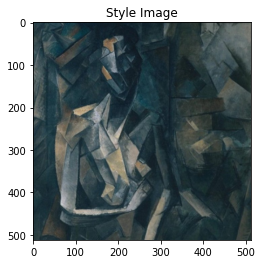

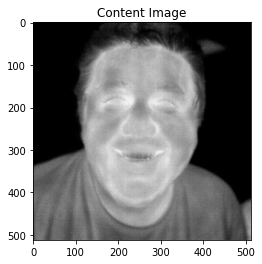

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 28.766205 Content Loss: 6.101233

run [100]:
Style Loss : 15.350519 Content Loss: 5.505391

run [150]:
Style Loss : 10.962803 Content Loss: 4.894234

run [200]:
Style Loss : 6.656816 Content Loss: 4.499783

run [250]:
Style Loss : 3.472390 Content Loss: 4.194409

run [300]:
Style Loss : 1.644045 Content Loss: 3.925830



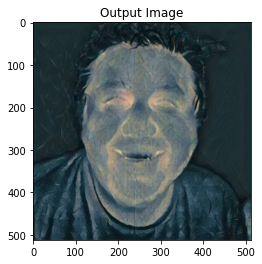

In [20]:
result_path = os.path.join(result_dir,'experiment_1_a.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-b : other selection of layers to calculate the loss functions

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_2, conv_4, conv_5|
 |__Style Layers__|conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

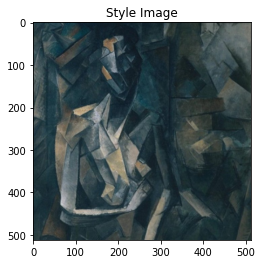

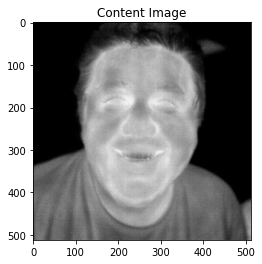

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 28.969625 Content Loss: 14.631486

run [100]:
Style Loss : 14.279694 Content Loss: 12.394568

run [150]:
Style Loss : 10.254333 Content Loss: 11.419061

run [200]:
Style Loss : 5.739902 Content Loss: 11.349674

run [250]:
Style Loss : 2.732200 Content Loss: 11.028478

run [300]:
Style Loss : 1.410043 Content Loss: 10.775322



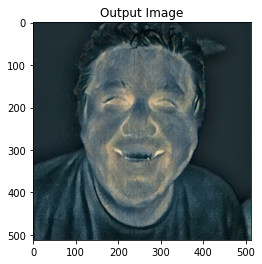

In [21]:
result_path = os.path.join(result_dir,'experiment_1_b.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_2', 'conv_4', 'conv_5'],
    style_layers = ['conv_1', 'conv_2', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-c : first combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|8000000|
 |__Content Weight__|1|

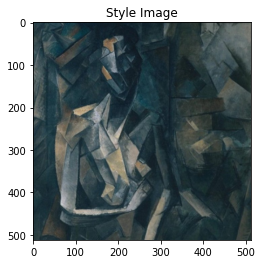

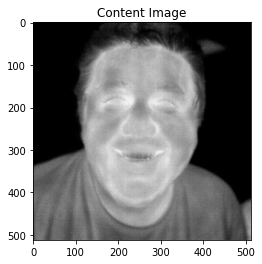

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 575.539612 Content Loss: 10.150639

run [100]:
Style Loss : 216.634628 Content Loss: 9.934544

run [150]:
Style Loss : 136.752441 Content Loss: 9.383925

run [200]:
Style Loss : 89.039383 Content Loss: 8.761171

run [250]:
Style Loss : 55.258423 Content Loss: 8.189836

run [300]:
Style Loss : 28.638351 Content Loss: 7.735956



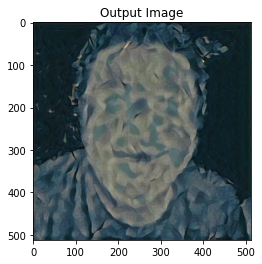

In [22]:
result_path = os.path.join(result_dir,'experiment_1_c.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 8000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-d : second combination for style loss (style weight) and content loss (content weight).

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|200|

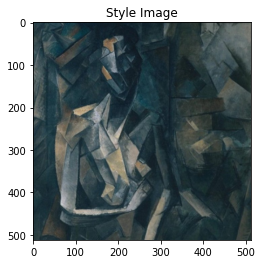

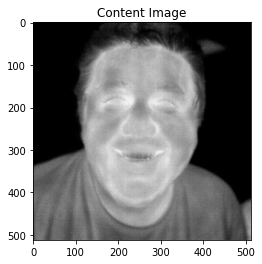

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 185.059158 Content Loss: 173.962692

run [100]:
Style Loss : 133.734604 Content Loss: 175.963623

run [150]:
Style Loss : 128.818222 Content Loss: 174.499634

run [200]:
Style Loss : 119.858231 Content Loss: 177.901199

run [250]:
Style Loss : 114.000298 Content Loss: 179.430511

run [300]:
Style Loss : 109.411743 Content Loss: 180.949417



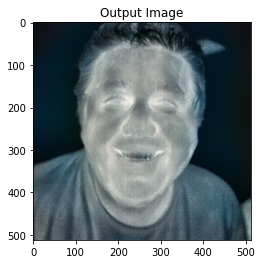

In [23]:
result_path = os.path.join(result_dir,'experiment_1_d.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 200,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-e : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

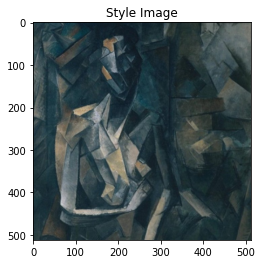

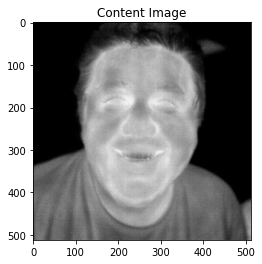

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.060334 Content Loss: 0.001593

run [100]:
Style Loss : 0.060030 Content Loss: 0.001742

run [150]:
Style Loss : 0.059930 Content Loss: 0.001786

run [200]:
Style Loss : 0.059876 Content Loss: 0.001809

run [250]:
Style Loss : 0.059830 Content Loss: 0.001824

run [300]:
Style Loss : 0.059788 Content Loss: 0.001838



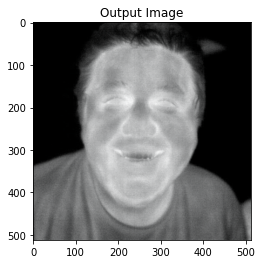

In [24]:
result_path = os.path.join(result_dir,'experiment_1_e.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-f : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_1|
 |__Style Weight__|80|
 |__Content Weight__|1|

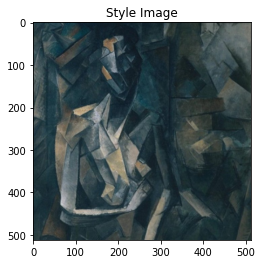

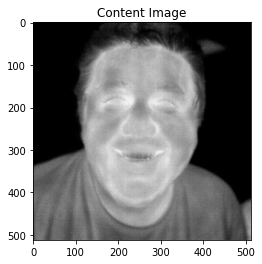

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.001403 Content Loss: 0.000000

run [100]:
Style Loss : 0.001403 Content Loss: 0.000000

run [150]:
Style Loss : 0.001403 Content Loss: 0.000000

run [200]:
Style Loss : 0.001403 Content Loss: 0.000000

run [250]:
Style Loss : 0.001403 Content Loss: 0.000000

run [300]:
Style Loss : 0.001403 Content Loss: 0.000000



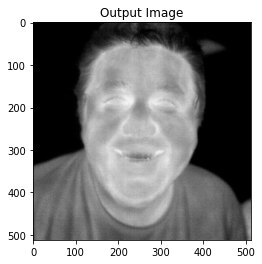

In [25]:
result_path = os.path.join(result_dir,'experiment_1_f.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_1'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 1-g : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

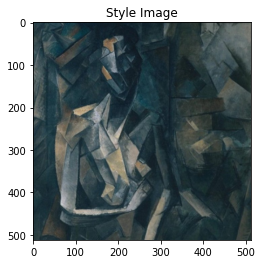

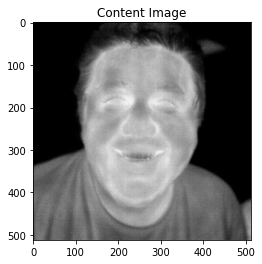

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.001646 Content Loss: 0.002867

run [100]:
Style Loss : 0.001643 Content Loss: 0.002947

run [150]:
Style Loss : 4.924622 Content Loss: 3.129252

run [200]:
Style Loss : 0.003035 Content Loss: 0.012688

run [250]:
Style Loss : 0.004655 Content Loss: 0.015346

run [300]:
Style Loss : 0.053261 Content Loss: 0.052337



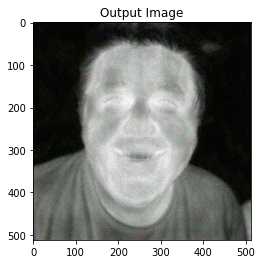

In [26]:
result_path = os.path.join(result_dir,'experiment_1_g.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/picasso.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-a : original values for hyperparameters

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

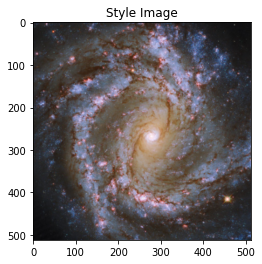

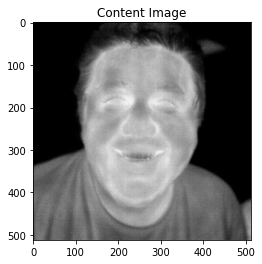

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 37.360435 Content Loss: 15.151316

run [100]:
Style Loss : 8.229709 Content Loss: 13.727972

run [150]:
Style Loss : 5.057376 Content Loss: 11.899552

run [200]:
Style Loss : 3.622369 Content Loss: 10.603817

run [250]:
Style Loss : 2.712692 Content Loss: 9.645593

run [300]:
Style Loss : 1.904608 Content Loss: 8.892296



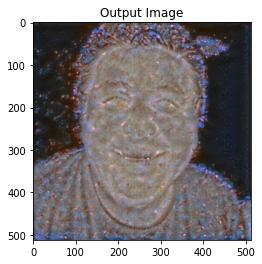

In [27]:
result_path = os.path.join(result_dir,'experiment_2_a.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-b : other selection of layers to calculate the loss functions

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_2, conv_4, conv_5|
 |__Style Layers__|conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

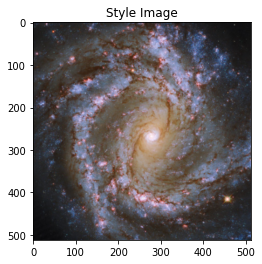

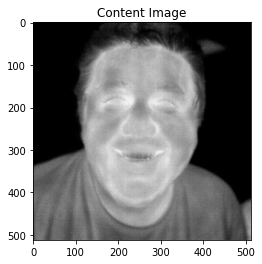

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 37.083881 Content Loss: 32.180527

run [100]:
Style Loss : 11.348165 Content Loss: 30.389294

run [150]:
Style Loss : 5.416590 Content Loss: 28.239414

run [200]:
Style Loss : 4.026061 Content Loss: 27.070103

run [250]:
Style Loss : 2.942547 Content Loss: 26.459133

run [300]:
Style Loss : 2.118188 Content Loss: 26.084249



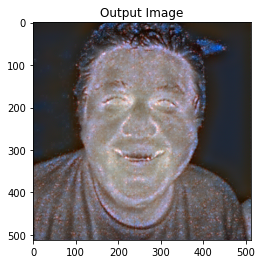

In [28]:
result_path = os.path.join(result_dir,'experiment_2_b.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_2', 'conv_4', 'conv_5'],
    style_layers = ['conv_1', 'conv_2', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-c : first combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|8000000|
 |__Content Weight__|1|

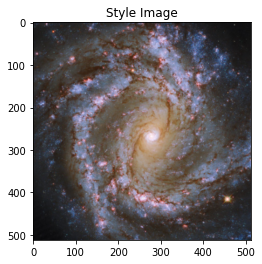

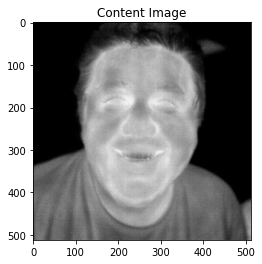

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 285.089172 Content Loss: 15.439150

run [100]:
Style Loss : 63.363892 Content Loss: 15.240382

run [150]:
Style Loss : 37.038849 Content Loss: 14.740399

run [200]:
Style Loss : 26.115780 Content Loss: 14.125389

run [250]:
Style Loss : 18.551872 Content Loss: 13.442467

run [300]:
Style Loss : 12.533891 Content Loss: 12.781908



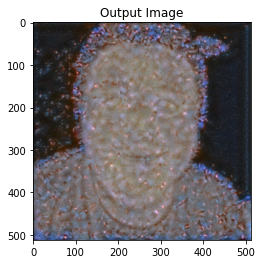

In [29]:
result_path = os.path.join(result_dir,'experiment_2_c.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 8000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-d : second combination for style loss (style weight) and content loss (content weight).

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|200|

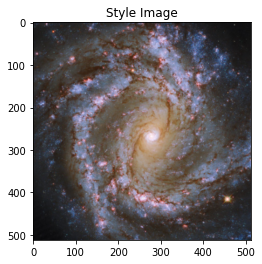

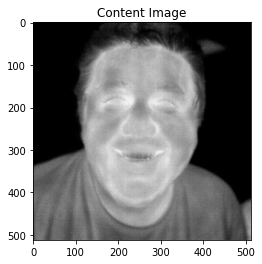

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 243.471909 Content Loss: 614.569336

run [100]:
Style Loss : 220.414917 Content Loss: 591.552002

run [150]:
Style Loss : 211.113556 Content Loss: 588.091736

run [200]:
Style Loss : 205.835800 Content Loss: 586.392944

run [250]:
Style Loss : 202.101089 Content Loss: 585.048035

run [300]:
Style Loss : 199.697906 Content Loss: 583.072083



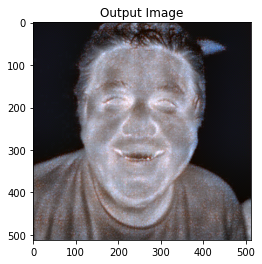

In [30]:
result_path = os.path.join(result_dir,'experiment_2_d.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 200,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-e : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

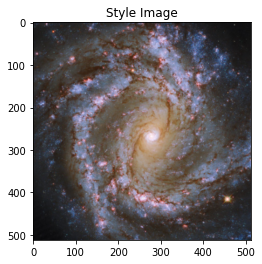

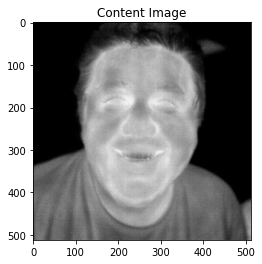

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.275538 Content Loss: 0.003519

run [100]:
Style Loss : 0.275046 Content Loss: 0.003764

run [150]:
Style Loss : 0.274811 Content Loss: 0.003889

run [200]:
Style Loss : 0.274686 Content Loss: 0.003950

run [250]:
Style Loss : 0.274593 Content Loss: 0.003999

run [300]:
Style Loss : 0.274531 Content Loss: 0.004030



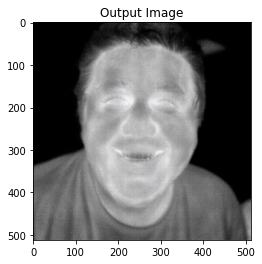

In [31]:
result_path = os.path.join(result_dir,'experiment_2_e.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-f : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_1|
 |__Style Weight__|80|
 |__Content Weight__|1|

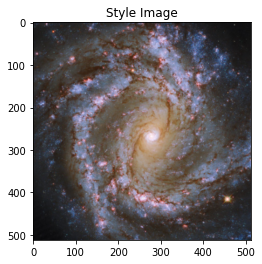

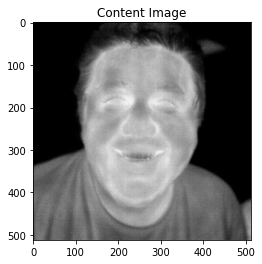

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.000801 Content Loss: 0.000000

run [100]:
Style Loss : 0.000801 Content Loss: 0.000000

run [150]:
Style Loss : 0.000801 Content Loss: 0.000000

run [200]:
Style Loss : 0.000801 Content Loss: 0.000000

run [250]:
Style Loss : 0.000801 Content Loss: 0.000000

run [300]:
Style Loss : 0.000801 Content Loss: 0.000000



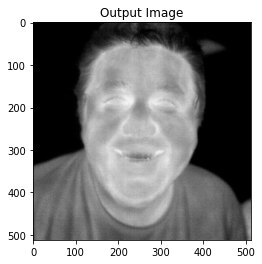

In [32]:
result_path = os.path.join(result_dir,'experiment_2_f.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_1'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 2-g : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

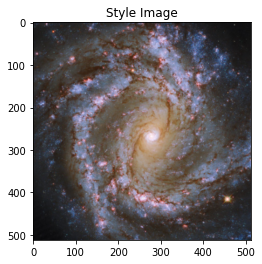

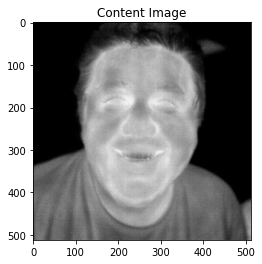

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.002857 Content Loss: 0.009972

run [100]:
Style Loss : 0.002805 Content Loss: 0.012463

run [150]:
Style Loss : 0.002605 Content Loss: 0.010408

run [200]:
Style Loss : 0.002687 Content Loss: 0.014387

run [250]:
Style Loss : 0.004830 Content Loss: 0.021406

run [300]:
Style Loss : 0.003256 Content Loss: 0.014901



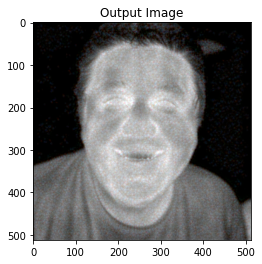

In [33]:
result_path = os.path.join(result_dir,'experiment_2_g.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_1.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-a : original values for hyperparameters

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

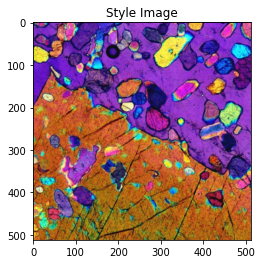

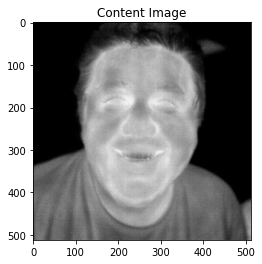

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 763.698242 Content Loss: 44.611935

run [100]:
Style Loss : 193.770569 Content Loss: 45.795422

run [150]:
Style Loss : 71.152855 Content Loss: 45.549984

run [200]:
Style Loss : 28.230156 Content Loss: 45.195732

run [250]:
Style Loss : 11.823363 Content Loss: 44.244518

run [300]:
Style Loss : 5.700553 Content Loss: 43.199913



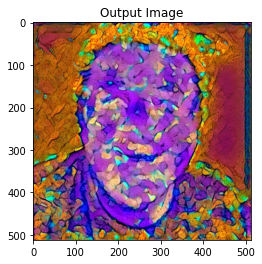

In [34]:
result_path = os.path.join(result_dir,'experiment_3_a.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-b : other selection of layers to calculate the loss functions

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_2, conv_4, conv_5|
 |__Style Layers__|conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|1|

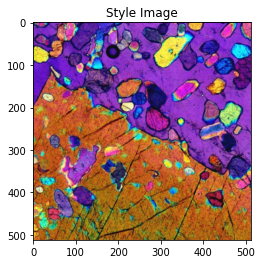

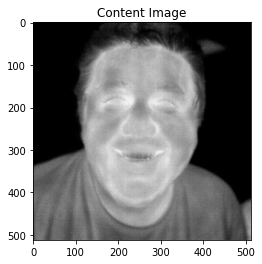

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 608.667664 Content Loss: 170.894409

run [100]:
Style Loss : 183.273788 Content Loss: 176.048340

run [150]:
Style Loss : 78.040764 Content Loss: 173.978485

run [200]:
Style Loss : 37.067276 Content Loss: 169.602814

run [250]:
Style Loss : 20.166502 Content Loss: 165.747375

run [300]:
Style Loss : 11.207067 Content Loss: 161.424408



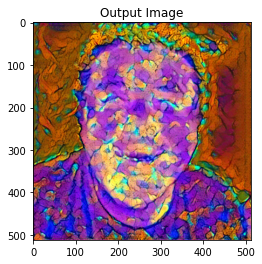

In [35]:
result_path = os.path.join(result_dir,'experiment_3_b.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_2', 'conv_4', 'conv_5'],
    style_layers = ['conv_1', 'conv_2', 'conv_5'],
    style_weight = 1000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-c : first combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|8000000|
 |__Content Weight__|1|

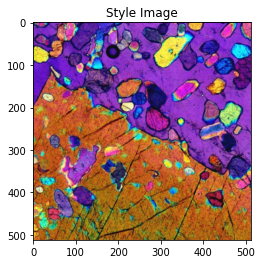

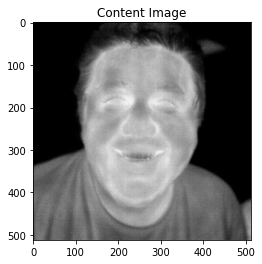

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 5938.032227 Content Loss: 44.921864

run [100]:
Style Loss : 1625.840576 Content Loss: 46.139053

run [150]:
Style Loss : 579.212646 Content Loss: 46.319111

run [200]:
Style Loss : 225.565536 Content Loss: 46.505409

run [250]:
Style Loss : 91.787384 Content Loss: 46.528419

run [300]:
Style Loss : 39.926197 Content Loss: 46.448696



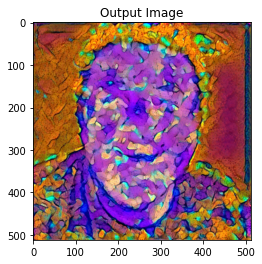

In [36]:
result_path = os.path.join(result_dir,'experiment_3_c.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 8000000,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-d : second combination for style loss (style weight) and content loss (content weight).

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|1000000|
 |__Content Weight__|200|

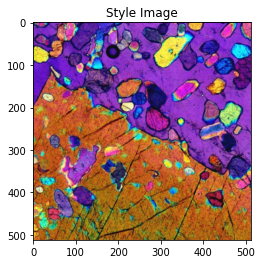

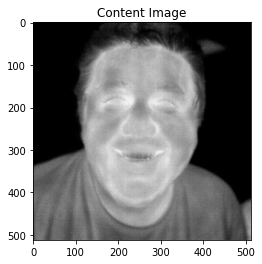

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 1569.776855 Content Loss: 5713.574707

run [100]:
Style Loss : 942.658997 Content Loss: 5169.096680

run [150]:
Style Loss : 841.867065 Content Loss: 4875.847656

run [200]:
Style Loss : 824.118347 Content Loss: 4760.309570

run [250]:
Style Loss : 821.129944 Content Loss: 4705.091309

run [300]:
Style Loss : 833.280457 Content Loss: 4709.646484



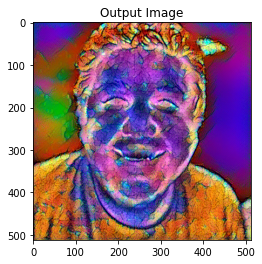

In [37]:
result_path = os.path.join(result_dir,'experiment_3_d.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 1000000,
    content_weight = 200,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-e : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_4|
 |__Style Layers__|conv_1, conv_2, conv_3, conv_4, conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

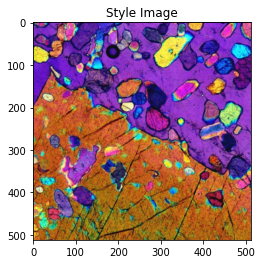

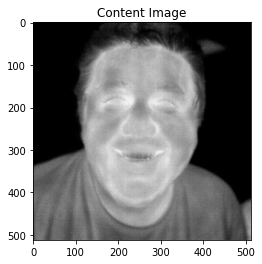

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 4.832123 Content Loss: 0.131533

run [100]:
Style Loss : 4.050049 Content Loss: 0.781766

run [150]:
Style Loss : 3.665902 Content Loss: 1.043409

run [200]:
Style Loss : 3.788522 Content Loss: 0.821038

run [250]:
Style Loss : 3.701399 Content Loss: 0.884642

run [300]:
Style Loss : 3.615494 Content Loss: 1.241610



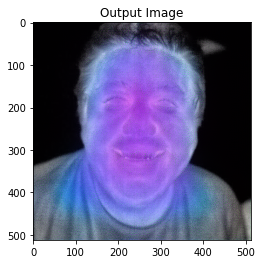

In [38]:
result_path = os.path.join(result_dir,'experiment_3_e.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_4'],
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-f : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_1|
 |__Style Weight__|80|
 |__Content Weight__|1|

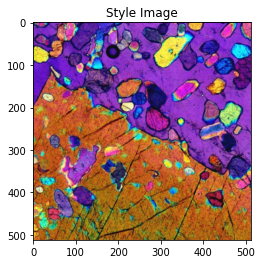

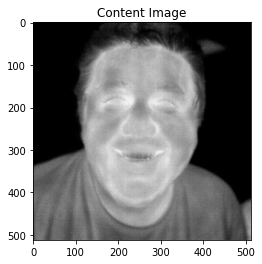

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.018994 Content Loss: 0.000000

run [100]:
Style Loss : 0.018993 Content Loss: 0.000000

run [150]:
Style Loss : 0.018993 Content Loss: 0.000000

run [200]:
Style Loss : 0.018993 Content Loss: 0.000000

run [250]:
Style Loss : 0.018992 Content Loss: 0.000000

run [300]:
Style Loss : 0.018992 Content Loss: 0.000000



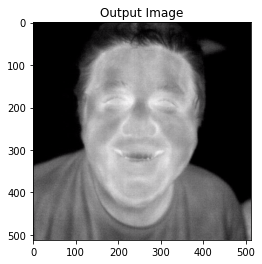

In [39]:
result_path = os.path.join(result_dir,'experiment_3_f.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_1'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)


 ## Experiment 3-g : third combination for style loss (style weight) and content loss (content weight)

 |__Parameter__|__Value__|
 |---------|-----|
 |__Content Layers__|conv_1|
 |__Style Layers__|conv_5|
 |__Style Weight__|80|
 |__Content Weight__|1|

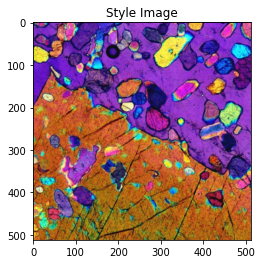

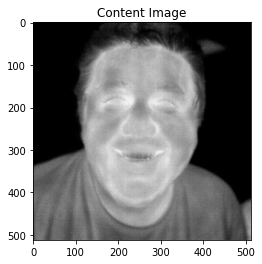

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.055119 Content Loss: 0.135088

run [100]:
Style Loss : 0.052576 Content Loss: 0.244126

run [150]:
Style Loss : 0.043918 Content Loss: 0.162479

run [200]:
Style Loss : 0.044396 Content Loss: 0.144573

run [250]:
Style Loss : 0.082163 Content Loss: 0.354350

run [300]:
Style Loss : 0.092860 Content Loss: 0.419812



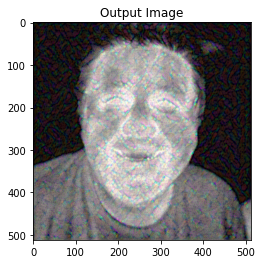

In [40]:
result_path = os.path.join(result_dir,'experiment_3_g.jpg')
run_pipeline(
    result_path,
    content_img_path = 'img/content_1.jpg', 
    style_img_path = 'img/style_2.jpg', 
    content_layers= ['conv_1'],
    style_layers = ['conv_5'],
    style_weight = 80,
    content_weight = 1,
    num_steps=300,
    check_img_size = True
)

Collect and Compress the results ...

In [41]:
!zip -r results.zip results

  adding: results/ (stored 0%)
  adding: results/question_2/ (stored 0%)
  adding: results/question_2/experiment_2_a.jpg (deflated 1%)
  adding: results/question_2/experiment_3_d.jpg (deflated 1%)
  adding: results/question_2/experiment_3_a.jpg (deflated 0%)
  adding: results/question_2/experiment_2_c.jpg (deflated 1%)
  adding: results/question_2/experiment_3_c.jpg (deflated 0%)
  adding: results/question_2/experiment_2_f.jpg (deflated 5%)
  adding: results/question_2/experiment_1_a.jpg (deflated 1%)
  adding: results/question_2/experiment_2_b.jpg (deflated 1%)
  adding: results/question_2/experiment_1_c.jpg (deflated 5%)
  adding: results/question_2/experiment_1_f.jpg (deflated 5%)
  adding: results/question_2/experiment_1_b.jpg (deflated 1%)
  adding: results/question_2/experiment_3_b.jpg (deflated 0%)
  adding: results/question_2/experiment_1_g.jpg (deflated 3%)
  adding: results/question_2/experiment_3_f.jpg (deflated 5%)
  adding: results/question_2/experiment_1_d.jpg (deflated 1